DeepLarning Couse HSE 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [37]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

data/caption_tokens.pcl
data/
data/image_codes.npy
data/raw_captions.pcl
data/Dog-and-Cat.jpg
data/blvc_googlenet.pkl


### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 8.25 s, sys: 1.04 s, total: 9.3 s
Wall time: 9.55 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


In [4]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [7]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [8]:
import theano
import theano.tensor as T

In [9]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features

sentence_mask = T.neq(sentences,PAD_ix)

In [10]:
import lasagne
from lasagne.layers import *

In [11]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask )

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [12]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors )

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [13]:
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)

#find out better recurrent architectures for bonus point

In [14]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print "output shape = ",predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [15]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:,:-1].reshape((-1,n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)
#mean over non-PAD tokens
loss = (loss*output_mask).sum() / output_mask.sum()

In [16]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,weights)

In [17]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [18]:
captions = np.array(captions)

In [21]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice,captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix
    

In [22]:
generate_batch(img_codes,captions,3)

(array([[ -1.71427166,  -2.56418943,   2.28435993, ...,  -2.96478438,
          -0.25445342,   2.84464216],
        [  1.42498362,  -1.81265986,  -2.71935201, ...,   3.73618007,
          10.73064804,   1.78351355],
        [ -0.97825652,  -0.28946331,  -0.76397008, ...,  -1.83973718,
           0.27768636,  -1.984568  ]], dtype=float32),
 array([[ 8481,  8717,     0,  1380,  3400,   326,  8717,  4852,  8897,
          6787,  1380, 10058,   326, 10139,  1814,  2854,  3323,    64,
          3029,  8134],
        [ 8481,  8717,   779,  8528,  8717,  4431,  4859,  3180,  3980,
          8876,  4859,  8717,   608,  8134,    -1,    -1,    -1,    -1,
            -1,    -1],
        [ 8481,  8717,  5570,   781,  8717,  7083, 10222,  3980,  8717,
          3029,  4859,   308,  2854,  8717,  7586,  8134,    -1,    -1,
            -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [23]:
batch_size=50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch


In [24]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.74957204994, val loss: 5.6221983178


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.38479974916, val loss: 5.23358936069


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 5.10603377555, val loss: 4.96593871744


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.90641293326, val loss: 4.85779851021


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.72568760074, val loss: 4.58201725139


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.53183758961, val loss: 4.37782151926


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.36136906247, val loss: 4.38433863495


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.29696666434, val loss: 4.24574843391


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.1552093679, val loss: 4.1343858627


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.09243789318, val loss: 4.17809618682


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.05195773499, val loss: 3.84942317262


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.97766504707, val loss: 4.00166951684


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.89268092606, val loss: 3.90939595465


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.83548474617, val loss: 3.75265058052


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.79063146049, val loss: 3.82697599759


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.78936864799, val loss: 3.6659833335


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.7015747908, val loss: 3.64619470085


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.6914880731, val loss: 3.61544477542


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.62296358096, val loss: 3.48426195315


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.6172314425, val loss: 3.56556080793


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.55042008089, val loss: 3.64866613732


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.51731271947, val loss: 3.61983156887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.50294417784, val loss: 3.60871689244


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.50164832295, val loss: 3.40708855056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.43759826349, val loss: 3.3576326408


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.40069915774, val loss: 3.40388176235


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.41333740425, val loss: 3.4867647559


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.3825370853, val loss: 3.3362501937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.37855109592, val loss: 3.3357198501


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.35285306665, val loss: 3.38870871254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.34363682098, val loss: 3.23411828241


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.32550566309, val loss: 3.31748071956


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.31064625435, val loss: 3.27493149937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.27523208533, val loss: 3.3427654854


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.25956046777, val loss: 3.27220747294


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.23249389677, val loss: 3.22317204414


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 3.25435031493, val loss: 3.33072239782


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 3.28110443519, val loss: 3.24413532171


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.20253060112, val loss: 3.10462853126


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.21343670272, val loss: 3.20642050749


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 3.19150996763, val loss: 3.0799978602


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.18109190746, val loss: 3.31507260682


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.16642762011, val loss: 3.25865455041


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.14334507861, val loss: 3.1067779214


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.15882733902, val loss: 3.16933561136


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 3.13107960269, val loss: 3.22525526229


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.12398432575, val loss: 3.02524120731


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 3.13416860659, val loss: 3.07627708459


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 3.160025659, val loss: 3.08794972449


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 3.09427285682, val loss: 3.12946608874


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 3.09787969526, val loss: 3.01124875398


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 3.07849607817, val loss: 3.10432079019


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 3.12580070451, val loss: 3.14454921313


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 3.08883618061, val loss: 2.91668470516


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 3.06570056492, val loss: 3.03746505726


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 3.05456419693, val loss: 3.18809048956


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 3.00581087344, val loss: 3.06257161262


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 3.04544573324, val loss: 2.99085753444


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 3.03790520655, val loss: 2.95810487418


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 3.01893604627, val loss: 3.0522544262


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 3.0475011995, val loss: 3.0502620358


KeyboardInterrupt: 

### apply trained model

In [25]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

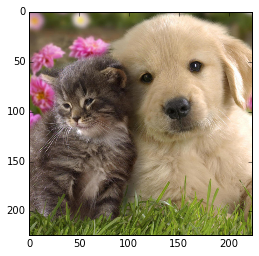

In [27]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [39]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [40]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

small stuffed teddy bear who is delivering a sleeping
dog close up using a cat in the background
white dog sitting in front of the wooden raised
large big pink dog within a boat
low cat sits standing asleep open grazing on the top of the grass
brown bear that with a kitten carved
boy girl sitting at a bear with its racquet
a calico gray cat sitting in front of a zebra on top of a den
tiny bears that is wading on the computer
curly baby is looking for the camera making a meal


# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio (see what `preprocess` does to your image)

In [ ]:
#apply your network on image sample you found
#
#

# some blah-blah on grading and points